In [1]:
%reload_ext autoreload

In [103]:
import hydra
import timm
from omegaconf import DictConfig, OmegaConf
from pathlib import Path
import lightning as L
import matplotlib.pyplot as plt
from src.models.binary_grid_module import BinaryGridLightningModule
from src.data.toy_datamodule import ToyDataModule
import torch
from torchmetrics.classification.accuracy import BinaryAccuracy
from torchmetrics.functional.classification.accuracy import binary_accuracy
import torch.nn.functional as F

In [56]:
# cd to parent directory with file .project_root
while not Path('.project-root').exists():
    %cd ..
print(f"Current working directory: {Path.cwd()}")

Current working directory: /Users/dgcnz/development/playground/pit_experiments


In [58]:
# This is how to setup the config
with hydra.initialize(version_base=None, config_path="../configs", job_name="test"):
    cfg = hydra.compose(config_name="train", overrides=["experiment=toy_mirror-pit_grid_small"])
    print(OmegaConf.to_yaml(cfg.model))

_target_: src.models.binary_grid_module.BinaryGridLightningModule
net:
  _target_: src.models.components.pixel_transformer.PixelTransformer
  img_size: 8
  embed_dim: 8
  depth: 4
  num_heads: 4
optimizer:
  _target_: torch.optim.AdamW
  _partial_: true
  lr: 0.001
  weight_decay: 1.0
  betas:
  - 0.9
  - 0.98
scheduler: null
compile: false



In [88]:
datamodule: ToyDataModule = hydra.utils.instantiate(cfg.data)
model: BinaryGridLightningModule = hydra.utils.instantiate(cfg.model)

In [50]:
datamodule.setup("train")
train_dataloader = datamodule.train_dataloader()

In [51]:
x, y = next(iter(train_dataloader))

In [95]:
loss, preds, y = model.model_step((x, y))
flipped_preds = torch.flip(preds, dims=[-1])

In [96]:
preds[0]

tensor([[[0.5083, 0.4794, 0.5085, 0.5092, 0.4802, 0.5087, 0.4799, 0.4793],
         [0.5094, 0.5094, 0.5087, 0.5088, 0.5092, 0.4797, 0.4788, 0.5088],
         [0.5082, 0.4792, 0.4800, 0.5094, 0.4800, 0.5083, 0.4800, 0.4793],
         [0.4793, 0.5092, 0.4816, 0.4776, 0.4788, 0.5084, 0.5090, 0.5089],
         [0.5084, 0.4803, 0.4790, 0.5082, 0.5092, 0.5094, 0.4805, 0.5089],
         [0.4795, 0.5088, 0.5089, 0.5088, 0.5092, 0.4799, 0.5086, 0.4798],
         [0.4799, 0.4805, 0.4798, 0.5084, 0.5088, 0.4802, 0.4797, 0.4792],
         [0.4795, 0.5092, 0.4789, 0.5093, 0.5091, 0.4782, 0.5090, 0.4802]]],
       grad_fn=<SelectBackward0>)

In [97]:
model.net(x)

tensor([[[[ 0.0333, -0.0825,  0.0341,  ...,  0.0350, -0.0805, -0.0827],
          [ 0.0375,  0.0378,  0.0347,  ..., -0.0812, -0.0847,  0.0352],
          [ 0.0327, -0.0832, -0.0799,  ...,  0.0333, -0.0801, -0.0827],
          ...,
          [-0.0820,  0.0352,  0.0355,  ..., -0.0806,  0.0344, -0.0808],
          [-0.0806, -0.0782, -0.0810,  ..., -0.0791, -0.0810, -0.0834],
          [-0.0819,  0.0369, -0.0846,  ..., -0.0872,  0.0360, -0.0793]]],


        [[[ 0.0333,  0.0348,  0.0340,  ..., -0.0813, -0.0805,  0.0339],
          [ 0.0375,  0.0378, -0.0812,  ..., -0.0812,  0.0341, -0.0803],
          [-0.0856, -0.0832,  0.0356,  ...,  0.0333, -0.0801,  0.0346],
          ...,
          [-0.0820, -0.0811,  0.0355,  ..., -0.0806,  0.0344,  0.0349],
          [ 0.0367, -0.0782, -0.0810,  ..., -0.0791,  0.0356, -0.0834],
          [ 0.0356, -0.0777,  0.0333,  ..., -0.0872, -0.0815, -0.0793]]],


        [[[ 0.0334, -0.0825,  0.0341,  ...,  0.0350,  0.0366, -0.0826],
          [ 0.0375,  0.037

In [98]:
# round preds to 0 or 1
rounded_preds = torch.round(preds)
rounded_preds[0]

tensor([[[1., 0., 1., 1., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1.],
         [1., 0., 0., 1., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1., 1., 0., 1.],
         [0., 1., 1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 1., 0., 1., 1., 0., 1., 0.]]], grad_fn=<SelectBackward0>)

In [100]:
criterion(preds, y)

tensor(0.7290, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

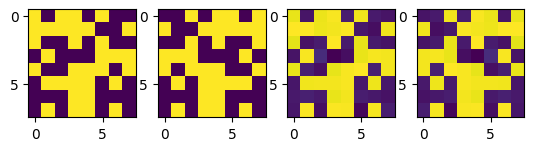

In [94]:
fig, ax = plt.subplots(1,4)
ax[0].imshow(x[0].squeeze().numpy())
ax[1].imshow(y[0].squeeze().numpy())
ax[2].imshow(preds[0].squeeze().detach().numpy())
ax[3].imshow(flipped_preds[0].squeeze().detach().numpy())

In [110]:
# if preds are >= 0.5 then 1 else 0
rounded_preds = (preds > 0.5).float()
rounded_flipped_preds = (flipped_preds > 0.5).float()
print(rounded_preds[0])

tensor([[[1., 0., 1., 1., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1.],
         [1., 0., 0., 1., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1., 1., 0., 1.],
         [0., 1., 1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 1., 0., 1., 1., 0., 1., 0.]]])


In [111]:
print(F.binary_cross_entropy(preds, y))
print(F.binary_cross_entropy(flipped_preds, y))
print(F.binary_cross_entropy(rounded_preds, y))
print(F.binary_cross_entropy(rounded_flipped_preds, y))
print(binary_accuracy(preds, y))
print(binary_accuracy(flipped_preds, y))
print(binary_accuracy(rounded_preds, y))
print(binary_accuracy(rounded_flipped_preds, y))

tensor(0.6946, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6643, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(51.9531)
tensor(0.)
tensor(0.4805)
tensor(1.)
tensor(0.4805)
tensor(1.)


/var/folders/rk/fqb5s6dn6sl66ntxp1ssybz80000gn/T/ipykernel_3395/689098146.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


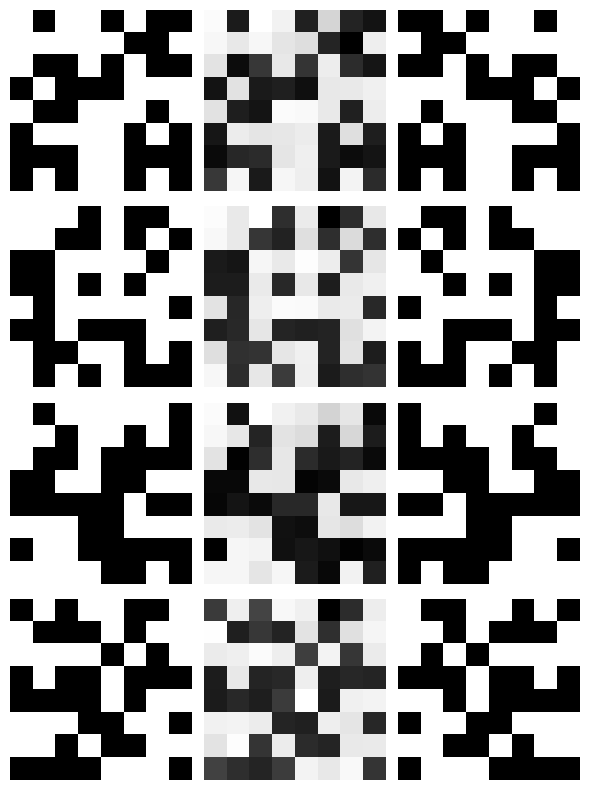

In [65]:
fig, axes = plt.subplots(4, 3, figsize=(6, 8))
for i in range(4):
    axes[i, 0].imshow(x[i, 0], cmap='gray')
    axes[i, 1].imshow(preds[i][0].detach().numpy(), cmap='gray')
    axes[i, 2].imshow(y[i, 0], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
fig.tight_layout()
fig.show()


In [8]:
from src.models.binary_grid_module import BinaryGridLightningModule
import torch

In [9]:
net=PixelTransformer(8, 1, 64, 8, 8)

In [10]:
net(torch.rand(2, 1, 8, 8)).shape

torch.Size([2, 1, 8, 8])

In [11]:
train = datamodule.train_dataloader()
x = next(iter(train))

In [12]:
x[1].shape

torch.Size([32, 1, 8, 8])

In [17]:
from functools import partial

In [22]:
model = BinaryGridLightningModule(
    net=net,
    optimizer=partial(torch.optim.Adam, lr=1e-4, weight_decay=1e-2),
    scheduler=None,
    compile=False
)

/Users/dgcnz/development/playground/pit_experiments/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [23]:
import lightning as L

In [24]:
trainer = L.Trainer(max_epochs=100, accelerator="mps")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, datamodule)


  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | net          | PixelTransformer  | 404 K  | train
1 | criterion    | BCEWithLogitsLoss | 0      | train
2 | train_acc    | BinaryAccuracy    | 0      | train
3 | val_acc      | BinaryAccuracy    | 0      | train
4 | test_acc     | BinaryAccuracy    | 0      | train
5 | train_loss   | MeanMetric        | 0      | train
6 | val_loss     | MeanMetric        | 0      | train
7 | test_loss    | MeanMetric        | 0      | train
8 | val_acc_best | MaxMetric         | 0      | train
-----------------------------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.617     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/dgcnz/development/playground/pit_experiments/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/dgcnz/development/playground/pit_experiments/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/dgcnz/development/playground/pit_experiments/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [23]:
x[0].shape

torch.Size([32, 1, 8, 8])